In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from itertools import combinations

from fetch import *

In [ ]:
# Here are the lists and dictionaries that were imported from the fetch.py file
print(f'base_list = {base_list}')
print(f'ensemble_list = {ensemble_list}')
print(f'state_chamber_list = {state_chamber_list}')
print(f'primary_score_list = {primary_score_list}')
print(f'secondary_score_list = {secondary_score_list}')
print(f'num_seats_dict = {num_seats_dict}')

base_list = ['base0', 'base1', 'base2', 'base3', 'base4']
ensemble_list = ['pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'county25', 'county50', 'county75', 'county100']
state_chamber_list = [('FL', 'congress'), ('FL', 'upper'), ('FL', 'lower'), ('IL', 'congress'), ('IL', 'upper'), ('IL', 'lower'), ('MI', 'congress'), ('MI', 'upper'), ('MI', 'lower'), ('NC', 'congress'), ('NC', 'upper'), ('NC', 'lower'), ('NY', 'congress'), ('NY', 'upper'), ('NY', 'lower'), ('OH', 'congress'), ('OH', 'upper'), ('OH', 'lower')]
primary_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin', 'MMD black', 'MMD hispanic', 'MMD coalition', 'county_splits', 'counties split']
secondary_score_list = ['efficiency_gap_statewide', 'estimated_seats', 'disproportionality', 'pr_deviation', 'proportionality', 'efficiency_gap', 'seats_bias', 'votes_bias', 'declination', 'mean_median_statewide', 'turnout

In [3]:
def kde_plot(state, chamber, ensemble_list, score, average_lines = True): # kde plot of any given list of ensembles
    """
    For the given state, chamber, and score, this plots one KDE for each ensembles in ensemble_list.
    """
    prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get the color cycle
    for i, ensemble in enumerate(ensemble_list):
        color = prop_cycle[i % len(prop_cycle)]  # Cycle through colors
        a = fetch_score_array(state, chamber, ensemble, score)
        sns.kdeplot(a, label=ensemble, color=color)
        if average_lines:
            plt.axvline(np.mean(a), linestyle='--', color=color)
    plt.title(f'{state} {chamber} {score}')
    plt.xlabel(score)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

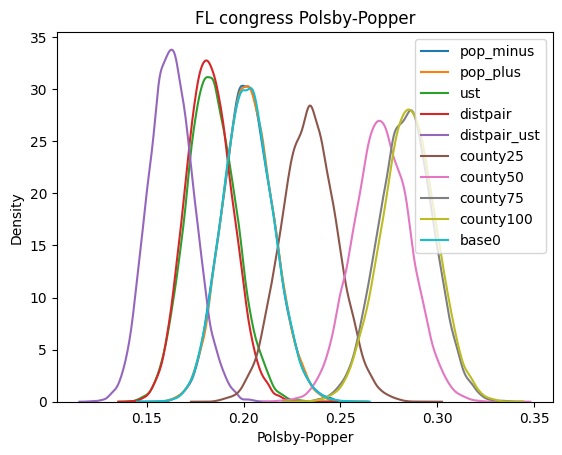

In [7]:
state = 'FL' 
chamber = 'congress'
score = 'Polsby-Popper'
kde_plot(state, chamber, ensemble_list + ['base0'], score, average_lines=False)

In [9]:
def box_plot(state, chamber, ensemble_list, competitive_window = .05):
    """
    For the given state and chamber, this superimposes ordered-seats-plots for the two ensembles in ensemble_list.
    Each ensemble is colored differently.
    The size of ensemble_list must be 2.
    It only includes seats that are competitive for at least one of the ensembles.
    (this means that the dem seat share is within competitive_window of 0.5 for at least one ensemble)
    """
    if len(ensemble_list) != 2:
        raise ValueError('ensemble_list must have length 2')
    X0 = fetch_score_array(state, chamber, ensemble_list[0], 'by_district')
    X1 = fetch_score_array(state, chamber, ensemble_list[1], 'by_district')

    seats_list = []
    for i in range(1, X0.shape[1]+1):
        if abs(np.mean(X0[:, i-1]) - 0.5) < competitive_window or abs(np.mean(X1[:, i-1]) - 0.5) < competitive_window:
            seats_list.append(i)

    fig, ax = plt.subplots(figsize=(10, 10))
    for i in seats_list:
        ax.boxplot(X0[:, i-1], positions=[i-.15], widths=0.3, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='black'), 
                    medianprops=dict(color='black'), 
                    flierprops=dict(markerfacecolor='white', marker=''))
        ax.boxplot(X1[:, i-1], positions=[i+0.15], widths=0.3, patch_artist=True, 
                    boxprops=dict(facecolor='lightgreen', color='black'), 
                    medianprops=dict(color='black'), 
                    flierprops=dict(markerfacecolor='white', marker=''))
    plt.xticks(np.arange(1, X0.shape[1]+1), np.arange(1, X0.shape[1]+1))
    plt.axhline(y=0.5, color='red', linestyle='--')
    plt.xlabel('Ordered Districts')
    plt.ylabel('Democrat Vote Share')
    plt.title(f'{state} {chamber}: Ordered Seats Plots for {ensemble_list[0]} and {ensemble_list[1]}')
    plt.legend([plt.Line2D([0], [0], color='lightblue', lw=4), plt.Line2D([0], [0], color='lightgreen', lw=4)],
               [ensemble_list[0], ensemble_list[1]], loc='upper left')
    plt.show()

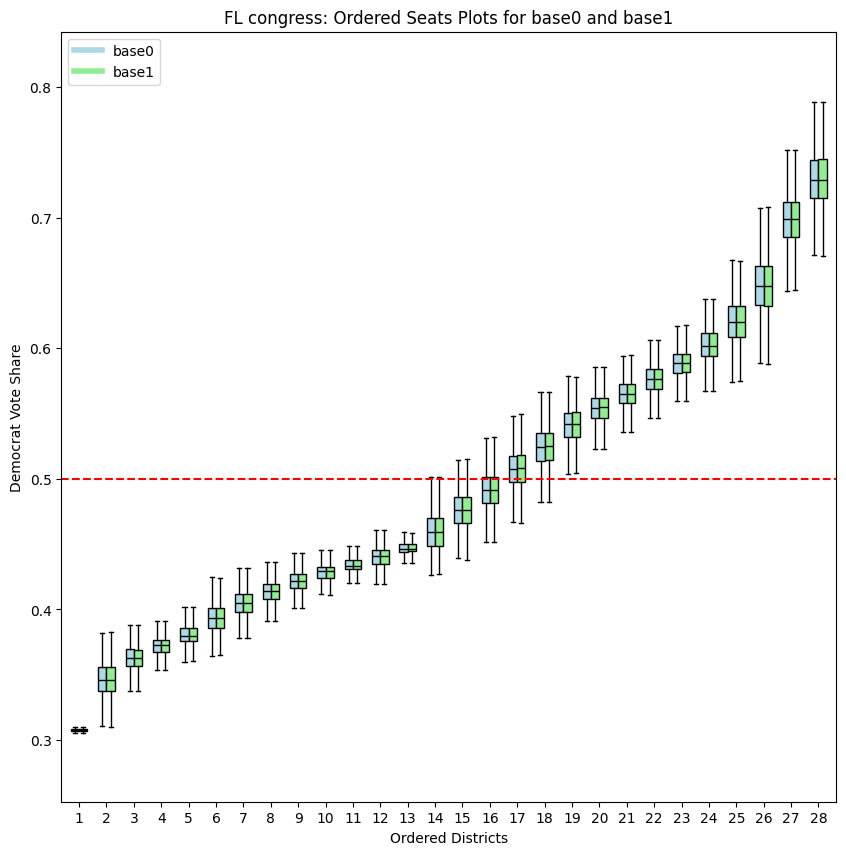

In [10]:
box_plot(state, chamber, ['base0', 'base1'], competitive_window=1)

Study the autocorrelations of individual ensembles

In [44]:
def autocorr(a): # lag 1 autocorrelation of the given array
    return np.corrcoef(a[:-1], a[1:])[0,1]

def summarize_autocorrelations(score_list, combine_method = 'max'):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the max/average/list (over the scores) of the lag-1 autocorrelation.
    Args:
        combine_method: 'max', 'mean', 'list' (default 'max')
    """
    column_list = ['base0'] + ensemble_list
    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    df = pd.DataFrame(columns = column_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in column_list:
            ls = []
            for score in score_list:
                a = fetch_score_array(state, chamber, ensemble, score)
                try:
                    with np.errstate(invalid='raise'):
                        ls.append(autocorr(a))
                except (FloatingPointError, RuntimeWarning):
                    ls.append(np.infty) # this happens for MMD scores that are zero over all maps.
            if combine_method == 'max':
                df.loc[f'{state}_{chamber}', ensemble] = max(ls)
            elif combine_method == 'mean':
                df.loc[f'{state}_{chamber}', ensemble] = np.mean(ls)
            elif combine_method == 'list':
                df.loc[f'{state}_{chamber}', ensemble] = np.array(ls)
    if combine_method != 'list':
        df = df.apply(pd.to_numeric)
    return df

In [ ]:
# I'll use a restricted score list here.  The MMD scores are constant at zero for certain states and chambers, 
# which causes the autocorrelation to be infinite.
df = summarize_autocorrelations(score_list = ['Polsby-Popper', 'Dem seats', 'competitive districts', 'efficiency gap'])

In [49]:
df.round(2)

,base0,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.02,0.03,0.02,0.02,0.03,0.01,0.03,0.08,0.10,0.10
FL_upper,0.01,0.02,0.02,0.01,0.03,0.04,0.02,0.10,0.12,0.11
FL_lower,0.08,0.09,0.08,0.07,0.07,0.06,0.09,0.09,0.11,0.12
IL_congress,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,0.03
IL_upper,0.04,0.03,0.02,0.02,0.03,0.01,0.05,0.08,0.09,0.11
IL_lower,0.05,0.07,0.05,0.02,0.06,0.02,0.06,0.09,0.12,0.10
MI_congress,0.01,0.00,-0.00,0.01,0.01,0.01,0.01,0.01,0.03,0.03
MI_upper,0.01,0.02,0.02,0.01,0.02,0.00,0.03,0.03,0.07,0.06
MI_lower,0.07,0.08,0.06,0.03,0.06,0.04,0.09,0.13,0.16,0.14
NC_congress,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0.00,0.00,0.00


Next study the closeness of each ensemble to the base0 ensemble

In [50]:
# statistical tests

def t_test(a1,a0): # runs the t-test of the hypotheses that two arrays were drawn from distributions with the same means.
    result = stats.ttest_ind(a1, a0, equal_var=False)
    return result.statistic, result.pvalue # the statistic is positive if a1 has a larger mean than a0

def ks_test(a0,a1): # runs the Kolmogorov-Smirnov test that the two arrays were drawn from the same distribution
    result = stats.ks_2samp(a0, a1)
    return result.statistic, result.pvalue, result.statistic_sign # the statistic_sign is positive if a1 has larger values than a0

In [51]:
# make dictionaries from which later dataframes will be created.
# Each dictionary will map (state, chamber, ensemble, score) to a specific measurement of closeness to the base0 ensemble.

my_ensemble_list =  ['base1', 'base2', 'base3', 'base4',
                     'pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'county25', 'county50', 'county75', 'county100']

mean_diff_dict = {}
KS_stat_dict = {}
KS_pvalue_dict = {}
T_pvalue_dict = {}

for state, chamber in state_chamber_list:
    for score in primary_score_list:
        a0 = fetch_score_array(state, chamber, 'base0', score)
        for ensemble in my_ensemble_list:
            a1 = fetch_score_array(state, chamber, ensemble, score)
            mean_diff = np.mean(a1) - np.mean(a0)
            KS_stat, KS_pvalue, KS_sign = ks_test(a0, a1)
            KS_signed_stat = KS_stat * KS_sign
            _, T_pvalue = t_test(a1, a0)

            mean_diff_dict[(state, chamber, ensemble, score)] = mean_diff
            KS_stat_dict[(state, chamber, ensemble, score)] = KS_signed_stat
            KS_pvalue_dict[(state, chamber, ensemble, score)] = KS_pvalue
            T_pvalue_dict[(state, chamber, ensemble, score)] = T_pvalue

In [54]:
def make_table(my_score_list = primary_score_list, my_ensemble_list= ensemble_list, my_state_chamber_list=state_chamber_list,
               based_on = 'ks_p', threshold = .001, display_extremes = True, transpose = True):
    """
    Create a dataframe whose columns are the scores and whose rows are the ensembles.
    Each cell contains a string of +, -, or 0, one for each state-chamber, to compare that ensemble's score to that of the base0 ensemble.
    if based_on == 'ks', the symbol indicates whether the KS statistic is above the threshold.
    if based_on == 'ks_p', it indicates whether the KS pvalue is below the threshold.
    if based_on == 't_p', it indicates whether the t-test pvalue is below the threshold.
    if display_extremes is True, the cell will also contain a dictionary with the state-chamber with 
    the largest and smallest KS-statistic (or mean-difference statistics if based_on='t_p').

    It returns the transpose if transpose is True.
    """
    df = pd.DataFrame(columns=my_score_list, index=my_ensemble_list).fillna('')
    for score in my_score_list:
        for ensemble in my_ensemble_list:
            string_of_symbols = ''
            min_stat = 0
            max_stat = 0
            max_state_chamber = ''
            min_state_chamber = ''
            for state, chamber in my_state_chamber_list:
                md = mean_diff_dict[state, chamber, ensemble, score]
                ks = KS_stat_dict[state, chamber, ensemble, score]
                ks_p = KS_pvalue_dict[state, chamber, ensemble, score]
                t_p = T_pvalue_dict[state, chamber, ensemble, score]

                if based_on == 'ks':
                    if np.abs(ks) > threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                if based_on == 't_p':
                    if t_p < threshold:
                        x = '+' if md > 0 else '-'
                    else:
                        x = '0'
                elif based_on == 'ks_p':
                    if ks_p < threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                string_of_symbols += x
                
                if x in ['+', '-']:
                    stat = ks if based_on in ['ks', 'ks_p'] else md
                    if stat > max_stat:
                        max_stat = stat
                        max_state_chamber = f'{state}_{chamber}'
                    if stat < min_stat:
                        min_stat = stat
                        min_state_chamber = f'{state}_{chamber}'

            if display_extremes:
                D = dict()
                if max_stat > 0:
                    D[max_state_chamber] = np.round(max_stat,3)
                if min_stat < 0:
                    D[min_state_chamber] = np.round(min_stat,3)
                if len(D) > 0:
                    df.at[ensemble, score] = f'{string_of_symbols}{D}'
                else:
                    df.at[ensemble, score] = string_of_symbols
            else:
                df.at[ensemble, score] = string_of_symbols

    if transpose:
        df = df.transpose()
    return df

In [57]:
# test that the other 4 base ensembles are all close to base0
test = make_table(my_ensemble_list=['base2', 'base3', 'base4'],
                    based_on = 'ks_p', threshold = .001, display_extremes=False)
test

,base2,base3,base4
Reock,000000000000000000,000000000000000000,00-000000000000000
Polsby-Popper,000000000000000000,000000000000000000,000000000000000000
cut edges,000000000000000000,000000000000000000,000000000000000000
Dem seats,000000000000000000,000000000000000000,000000000000000000
efficiency gap,000000000000000000,000000000000000000,000000000000000000
mean-median,000000000000000000,000000000000000000,000000000000000000
partisan bias,000000000000000000,000000000000000000,000000000000000000
competitive districts,000000000000000000,000000000000000000,000000000000000000
average margin,000000000000000000,000000000000000000,000000000000000000
MMD black,000000000000000000,000000000000000000,000000000000000000


In [59]:
compact_score_list = ['Reock', 'Polsby-Popper', 'cut edges']
partisan_score_list = ['Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin']
other_score_list = ['MMD coalition', 'county_splits']

base_ensemble_list = ['base1', 'base2', 'base3', 'base4']
ensemble_list = ['pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'county25', 'county50', 'county75', 'county100']
county_ensemble_list = ['county25', 'county50', 'county75', 'county100']
pop_ensemble_list = ['pop_minus', 'pop_plus']
recom_ensemble_list = ['ust', 'distpair', 'distpair_ust']

In [60]:
T = make_table(my_ensemble_list=pop_ensemble_list)
T.to_csv('pop_knob.csv')
T

,pop_minus,pop_plus
Reock,"00000+0-0000000000{'IL_lower': 0.025, 'MI_uppe...",0000000+0000000000{'MI_upper': 0.025}
Polsby-Popper,0--0000-000-0--000{'MI_upper': -0.083},0+000+0++0+000+000{'MI_upper': 0.047}
cut edges,0++0++0++00+0++00+{'MI_upper': 0.056},0--0--0--0-00--000{'FL_lower': -0.035}
Dem seats,000000000000000000,000000000000000000
efficiency gap,"0000+00+00-0000000{'IL_upper': 0.029, 'NC_uppe...","000+-00+0000000000{'MI_upper': 0.023, 'IL_uppe..."
mean-median,0000+0000000000000{'IL_upper': 0.021},000000000000000000
partisan bias,0000000000000--000{'NY_lower': -0.026},00000-000000000000{'IL_lower': -0.021}
competitive districts,0000-0000000000000{'IL_upper': -0.024},0000+0000000000000{'IL_upper': 0.021}
average margin,00-000000000000000{'FL_lower': -0.023},"0+00000000000--000{'FL_upper': 0.029, 'NY_uppe..."
MMD black,000000000000000000,000000000000000000


In [61]:
T = make_table(my_ensemble_list=recom_ensemble_list)
T.to_csv('recom_knob.csv')
T

,ust,distpair,distpair_ust
Reock,------------------{'NY_lower': -0.537},------------------{'NY_lower': -0.664},------------------{'NY_lower': -0.922}
Polsby-Popper,------------------{'NY_lower': -0.848},------------------{'NY_lower': -0.95},------------------{'NY_lower': -1.0}
cut edges,++++++++++++++++++{'NY_lower': 0.943},++++++++++++++++++{'NY_lower': 0.988},++++++++++++++++++{'NY_lower': 1.0}
Dem seats,"-00++0+0000000+-0-{'MI_congress': 0.051, 'OH_c...","--0+00++00+0+0+00-{'NY_congress': 0.054, 'FL_c...","--0++0++0-+0+0+---{'NY_lower': 0.1, 'FL_congre..."
efficiency gap,"+00+---000-0+0-+0+{'OH_congress': 0.056, 'MI_c...","++0-00--00-0-0-+0+{'FL_congress': 0.073, 'NY_c...","++0-----0+-0---+++{'FL_congress': 0.122, 'MI_c..."
mean-median,"+00000-00+-0-0-+--{'OH_congress': 0.09, 'MI_co...","0+++0+--00--+00+--{'OH_congress': 0.054, 'MI_c...","0+++00---+---00+--{'OH_congress': 0.146, 'MI_c..."
partisan bias,"++0-0---00-0-0-+--{'OH_congress': 0.129, 'MI_c...","++0-++---0-0-0-+-0{'FL_upper': 0.073, 'MI_cong...","++0-++---0-0---+--{'OH_congress': 0.182, 'MI_c..."
competitive districts,"+00000-00+++-++0+0{'FL_congress': 0.078, 'NY_c...","+0000+-+00++00+0+0{'FL_congress': 0.117, 'MI_c...","++++++-+00++-++-+0{'FL_congress': 0.217, 'MI_c..."
average margin,"---+--------+-----{'IL_congress': 0.039, 'FL_c...",---------0--------{'FL_congress': -0.181},------------------{'FL_congress': -0.329}
MMD black,00-0--0-00-----00-{'OH_lower': -0.085},00-------0--0--0--{'OH_lower': -0.106},00-------0-----0--{'OH_lower': -0.189}


In [62]:
T = make_table(my_ensemble_list=county_ensemble_list)
T.to_csv('county_knob.csv')
T

,county25,county50,county75,county100
Reock,+++++++++0+++++0++{'NC_lower': 0.329},++++++++++++++++++{'NC_lower': 0.651},++++++++++++++++++{'NC_lower': 0.781},++++++++++++++++++{'NC_lower': 0.796}
Polsby-Popper,++++++++++++++++++{'NC_upper': 0.887},++++++++++++++++++{'OH_upper': 1.0},++++++++++++++++++{'NC_upper': 1.0},++++++++++++++++++{'IL_lower': 1.0}
cut edges,------------------{'NY_congress': -0.676},------------------{'NY_congress': -0.954},------------------{'NC_upper': -0.98},------------------{'NC_upper': -0.979}
Dem seats,"++--0--0+-++-+0000{'FL_congress': 0.167, 'IL_c...","++--0--++-++-+0+-0{'FL_congress': 0.236, 'IL_c...","++-----++-++-+++-0{'FL_congress': 0.215, 'MI_c...","+++----++-++-+++-0{'FL_congress': 0.212, 'MI_c..."
efficiency gap,"--++0++--+--+-0-+0{'IL_lower': 0.051, 'FL_cong...","--++0++--+--+-0-+0{'IL_congress': 0.159, 'FL_c...","--+++++--+--+---+-{'IL_congress': 0.191, 'FL_c...","--0++++--+--+---+-{'IL_congress': 0.197, 'FL_c..."
mean-median,"-0--+++0-+--++0++-{'NY_upper': 0.103, 'FL_cong...","---+++-0-+--+++++-{'NY_upper': 0.176, 'FL_cong...","---++++0-+--+++++-{'IL_lower': 0.241, 'OH_lowe...","---++++0-+--+++++-{'IL_lower': 0.248, 'OH_lowe..."
partisan bias,"--00-000-+-----0+-{'OH_upper': 0.109, 'FL_cong...","--+0-0+--+-----++-{'OH_upper': 0.173, 'NY_uppe...","--+0-++--+-----++-{'OH_upper': 0.176, 'NY_uppe...","---0+++--+-----++-{'OH_upper': 0.17, 'NY_lower..."
competitive districts,"+-+-0+0-+0-0-----+{'FL_lower': 0.064, 'OH_uppe...","--+++++-+----0---+{'OH_lower': 0.125, 'OH_cong...","--+++++-+----0---+{'IL_lower': 0.202, 'OH_cong...","--+++++-+----0---+{'IL_lower': 0.237, 'OH_cong..."
average margin,"+++-++++-++++0++++{'NC_upper': 0.222, 'IL_cong...",++++++++++++++++++{'NC_upper': 0.484},"+++++-++++++++++++{'NC_upper': 0.59, 'IL_lower...","+++++-++++++++++++{'NC_lower': 0.616, 'IL_lowe..."
MMD black,"00-0++00-0++++0000{'NY_congress': 0.062, 'MI_l...","00-++++--0+++++000{'NY_upper': 0.141, 'MI_lowe...","00-++++--0+++++00-{'NY_upper': 0.184, 'FL_lowe...","00-++++--0+++++00-{'NY_upper': 0.181, 'MI_lowe..."


In [70]:
def score_table(score, pvalue = .001):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type)
    the closeness of that ensemble and the base0 ensemble with respect to the given score.
    It will mark * next to all values that are significantly different from the base0 ensemble.

    Args:
        score: use any valid score, or use 'Dem share' for 'Dem seats' divided by the number of seats.
        p_value: set to 1 if you don't want * marks.
    """

    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    columns_list = ['base1']+ ensemble_list
    df = pd.DataFrame(columns = columns_list, index = index_list)
    effective_score = 'Dem seats' if score == 'Dem share' else score
    for state, chamber in state_chamber_list:
        denom = num_seats_dict[(state, chamber)] if score == 'Dem share' else 1
        for ensemble in columns_list:
            mean_diff = mean_diff_dict[(state, chamber, ensemble, effective_score)] / denom
            mean_diff = np.round(mean_diff, 2)
            p_value = T_pvalue_dict[(state, chamber, ensemble, effective_score)]

            if p_value > pvalue:
                df.loc[f'{state}_{chamber}', ensemble] = f'{mean_diff}'
            else:
                df.loc[f'{state}_{chamber}', ensemble] = f'*{mean_diff}'

    return df

In [71]:
score_table('Dem share')

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.0,0.0,0.0,*-0.0,*-0.01,*-0.01,*0.02,*0.02,*0.02,*0.02
FL_upper,0.0,-0.0,0.0,-0.0,*-0.0,*-0.0,*0.0,0.0,*0.0,*0.0
FL_lower,0.0,0.0,0.0,-0.0,0.0,-0.0,*-0.0,*-0.0,*-0.0,*0.0
IL_congress,0.0,-0.0,-0.0,0.0,*0.0,*0.0,*-0.0,*-0.01,*-0.01,*-0.01
IL_upper,-0.0,-0.0,0.0,*0.0,-0.0,*0.0,-0.0,0.0,*-0.0,*-0.0
IL_lower,0.0,0.0,0.0,*0.0,-0.0,0.0,*-0.0,*-0.0,*-0.0,*-0.0
MI_congress,-0.0,0.0,0.0,*0.0,*0.0,*0.01,*-0.0,*-0.01,*-0.02,*-0.02
MI_upper,-0.0,-0.0,-0.0,0.0,*0.0,*0.0,0.0,*0.0,*0.0,*0.0
MI_lower,-0.0,-0.0,0.0,-0.0,0.0,0.0,*0.0,*0.0,*0.0,*0.0
NC_congress,0.0,0.0,-0.0,*-0.0,*-0.0,*-0.01,*-0.0,*-0.01,*-0.01,*-0.01


In [72]:
score_table('Dem seats')

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.0,0.01,0.0,*-0.11,*-0.18,*-0.29,*0.42,*0.59,*0.56,*0.55
FL_upper,0.02,-0.01,0.02,-0.02,*-0.09,*-0.14,*0.07,0.04,*0.05,*0.1
FL_lower,0.01,0.03,0.03,-0.0,0.01,-0.06,*-0.12,*-0.21,*-0.09,*0.07
IL_congress,0.0,-0.01,-0.0,0.01,*0.03,*0.04,*-0.06,*-0.23,*-0.23,*-0.21
IL_upper,-0.01,-0.03,0.04,*0.1,-0.01,*0.09,-0.03,0.0,*-0.07,*-0.15
IL_lower,0.01,0.03,0.0,*0.08,-0.05,0.01,*-0.14,*-0.14,*-0.22,*-0.35
MI_congress,-0.0,0.0,0.0,*0.06,*0.05,*0.09,*-0.04,*-0.16,*-0.26,*-0.27
MI_upper,-0.01,-0.0,-0.03,0.03,*0.07,*0.18,0.01,*0.11,*0.13,*0.14
MI_lower,-0.03,-0.02,0.01,-0.06,0.03,0.04,*0.23,*0.46,*0.53,*0.48
NC_congress,0.01,0.01,-0.0,*-0.05,*-0.03,*-0.08,*-0.04,*-0.07,*-0.08,*-0.09


In [73]:
score_table('competitive districts')

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,-0.02,-0.04,-0.01,*0.3,*0.46,*0.88,-0.03,*-0.09,*-0.11,*-0.1
FL_upper,-0.02,-0.02,*-0.06,0.05,0.03,*0.16,*-0.14,*-0.31,*-0.37,*-0.43
FL_lower,0.05,0.09,-0.0,*0.14,*0.11,*0.19,*0.45,*0.39,*0.28,*0.44
IL_congress,-0.0,-0.02,-0.01,0.02,*0.04,*0.06,*-0.16,0.01,*0.06,*0.05
IL_upper,-0.04,*-0.12,*0.1,*0.07,*0.08,*0.21,*-0.07,*0.13,*0.26,*0.37
IL_lower,0.0,-0.02,0.05,*0.1,*0.25,*0.34,*0.23,*0.78,*1.43,*1.65
MI_congress,0.0,-0.01,-0.0,*-0.06,*-0.07,*-0.15,0.01,*0.07,*0.12,*0.1
MI_upper,-0.02,0.03,-0.04,0.01,*0.35,*0.43,*-0.1,*-0.08,*-0.07,-0.06
MI_lower,0.02,-0.02,-0.03,-0.07,-0.08,-0.08,*0.34,*0.63,*0.76,*0.76
NC_congress,-0.01,0.0,0.01,*0.05,-0.01,0.04,0.0,*-0.08,*-0.14,*-0.16


Next, let's study how close the ordered seat plot of an ensemble is from that of the base0 ensemble

In [74]:
def Compare_ordered_seats(competitive_window = .05, metric = 'mean_diff', combine_method = 'max',
                          plot_threshold = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the "distance" between the ordered seats plots of the ensemble and the base0 ensemble.
    It only considers seats that are competitive for at least one of the two ensembles being compared,
    (which means that dem share is within competitive_window of 0.5 for at least one of the two ensembles).
    Args:
        competitive_window: the window around 0.5 that defines a competitive seat (default .05)
        metric: 'mean_diff' or 'ks' to measure, for each seat, the distance between the two histograms 
        combine_method: 'max', 'mean' (default 'max')
        plot_threshold: if not None, it plots an ordered-seats plot for each cell of the returned dataframe past the threshold.
    """
    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    columns_list = ['base1', 'pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'county25', 'county50', 'county75', 'county100']
    df = pd.DataFrame(columns = columns_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in columns_list:
            X0 = fetch_score_array(state, chamber, 'base0', 'by_district')
            X1 = fetch_score_array(state, chamber, ensemble, 'by_district')
            num_seats = X0.shape[1]
            ls = []
            for i in range(num_seats):
                if abs(np.mean(X0[:, i]) - 0.5) < competitive_window or abs(np.mean(X1[:, i]) - 0.5) < competitive_window:
                    if metric == 'mean_diff':
                        closeness = abs(np.mean(X1[:, i]) - np.mean(X0[:, i]))
                    elif metric == 'ks':
                        closeness, _, __ = ks_test(X1[:, i], X0[:, i])
                    else:
                        raise ValueError('metric must be mean_diff or ks')
                    ls.append(closeness)
                    
            combined_closeness = max(ls) if combine_method == 'max' else np.mean(ls)
            df.loc[f'{state}_{chamber}', ensemble] = combined_closeness
            if plot_threshold is not None and combined_closeness > plot_threshold:
                box_plot(state, chamber, [ensemble, 'base0'], competitive_window=competitive_window)
    df = df.apply(pd.to_numeric)
    return df

In [76]:
df = Compare_ordered_seats()

In [77]:
df.round(2)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.01
FL_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
FL_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
IL_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.01,0.01
IL_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
IL_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
MI_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.01
MI_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
MI_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
NC_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [79]:
dfm = Compare_ordered_seats(metric='ks')

In [80]:
dfm.round(2)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.02,0.02,0.02,0.09,0.13,0.24,0.18,0.30,0.30,0.29
FL_upper,0.02,0.04,0.07,0.02,0.04,0.07,0.06,0.11,0.13,0.16
FL_lower,0.01,0.03,0.01,0.03,0.03,0.05,0.07,0.09,0.09,0.09
IL_congress,0.01,0.01,0.01,0.07,0.04,0.06,0.09,0.21,0.25,0.25
IL_upper,0.01,0.02,0.03,0.04,0.03,0.07,0.05,0.13,0.17,0.20
IL_lower,0.01,0.02,0.02,0.04,0.03,0.07,0.04,0.13,0.22,0.26
MI_congress,0.01,0.01,0.01,0.09,0.07,0.15,0.04,0.15,0.21,0.22
MI_upper,0.01,0.03,0.05,0.02,0.08,0.14,0.04,0.10,0.13,0.14
MI_lower,0.01,0.02,0.02,0.02,0.04,0.04,0.08,0.19,0.25,0.26
NC_congress,0.01,0.01,0.03,0.03,0.03,0.07,0.03,0.08,0.12,0.12


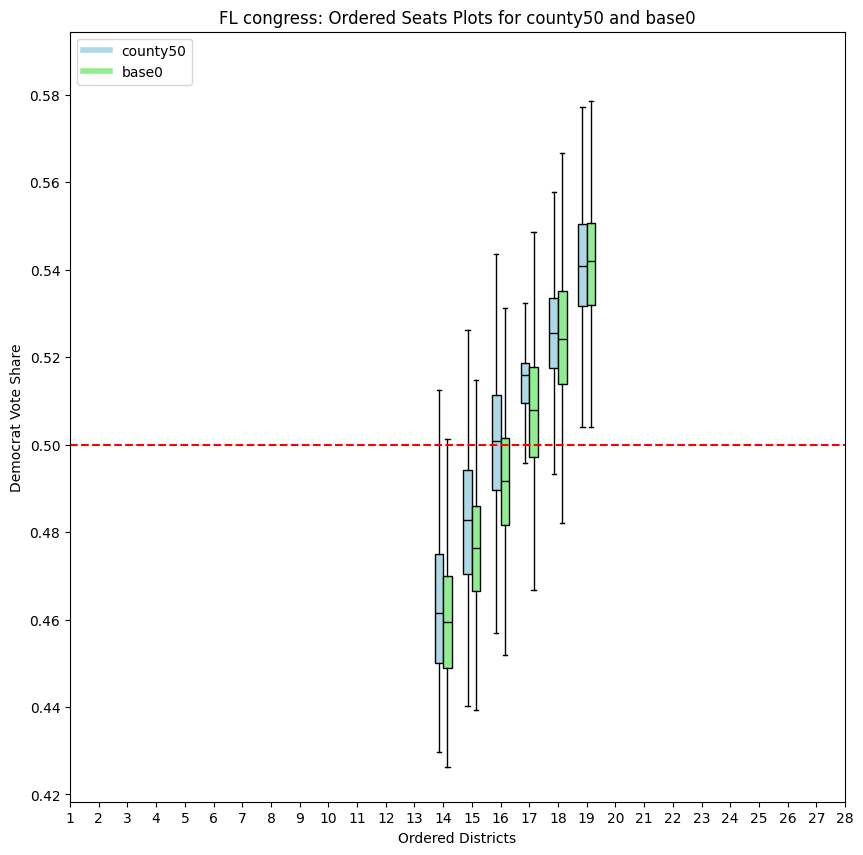

In [81]:
# let's look at a particular ensemble with a high KS-value:
box_plot('FL', 'congress', ['county50', 'base0'], competitive_window=.05)